<a href="https://colab.research.google.com/github/Pernach/PythonProjects/blob/main/Pitch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import lstm 

In [2]:
H = torch.tensor([[1], [0]])
omega = 0.6
betta = 0.98*omega
alpha = 0.21*betta
F = torch.tensor([[0, 1], [-(alpha**2 + betta**2), -2*alpha]])
A_max = 1.8
#sigma = A_max/3
sigma = 0.5
G = torch.tensor([[0, sigma*np.sqrt(4*alpha*(alpha**2 + betta**2))]])
P = torch.tensor([[sigma**2, 0], [0, (sigma**2)/(alpha**2 + betta**2)]])
P

tensor([[0.2500, 0.0000],
        [0.0000, 0.6925]])

In [3]:
dt = 0.05
Fd = torch.eye(2,2) + F*dt
Gd = (G*dt).T
Gd

tensor([[0.0000],
        [0.0106]], dtype=torch.float64)

In [4]:
# Создадим выборки
# Для начала одну большую обучающую
#x0 = torch.normal(mean = 0.0, std = 1.0, size = (2,1))
x0 = (torch.sqrt(P)).double().mm(torch.normal(mean = 0.0, std = 1.0, size = (2,1)).double())
X_for_train = torch.normal(mean = 0.0, std = 1.0, size = (1,80000))
w = torch.normal(mean = 0.0, std = 1/np.sqrt(dt), size = (1,80000))

In [5]:
R = 10e-10
Rd = R/dt
Rd

2e-08

In [6]:
x_tr = torch.zeros(2,len(w[0]))
x_tr[:,0] = x0.T
for i in range(1,len(w[0])):
  l = torch.tensor([[x_tr[0,(i-1)]],[x_tr[1,(i-1)]]]) 
  s = Fd.double().mm(l.double())  
  k = Gd.double() * w[:,i]
  x_tr[:,i] = (s + k).T
  

In [2]:
def discretize_F(F, G, dt):
  result1 = torch.eye(2,2) + F*dt
  result2 = (G*dt).T
  return result1, result2

In [5]:
# Определим фильтр
def Filter_d(array, alpha, betta, sigma, dt, R):
  F = torch.tensor([[0, 1], [-(alpha**2 + betta**2), -2*alpha]]) # матрица динамики
  G = torch.tensor([[0, sigma*np.sqrt(4*alpha*(alpha**2 + betta**2))]]) # Матрица порождающих шумов
  H = torch.tensor([[1], [0]]) # Матрица состояния
  Fd, Gd = discretize_F(F, G, dt) # Дискретизация первого порядка (достаточно для этого времени дискретизации в сравнении с периодом качки)
  P = torch.tensor([[sigma**2, 0], [0, (sigma**2)/(alpha**2 + betta**2)]]) # Начальное состояние фильтра
  Rd = R/dt
  res0 = (torch.sqrt(P)).double().mm(torch.normal(mean = 0.0, std = 1.0, size = (2,1)).double()) #Первое значение
  #w = torch.normal(mean = 0.0, std = 1/np.sqrt(dt), size = (1,len(array[0])))
  result = torch.zeros(2,len(array[0]))
  result[:,0] = res0.T
  for i in range(1,len(array[0])):
    l = torch.tensor([[result[0,(i-1)]],[result[1,(i-1)]]]) 
    s = Fd.double().mm(l.double())  
    k = Gd.double() * array[:,i]
    result[:,i] = (s + k).T
  return result

In [8]:
omega = 0.6
dt = 0.05
w = torch.normal(mean = 0.0, std = 1/np.sqrt(dt), size = (1,80000))
xx = Filter_d(w, 0.21*0.98*omega, 0.98*omega, 0.5, dt, 10e-10)

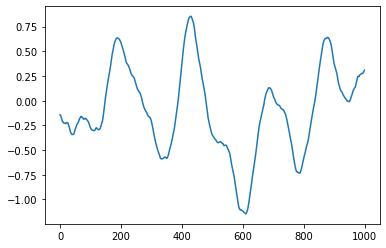

In [9]:
plt.plot(xx[0,4000:5000])